## || chapter 03. 평가 ||

### 00-1. 성능 평가 지표
   - 머신러닝의 프로세스
     - 1) 데이터 가공/변환
     - 2) 모델 학습/예측
     - 3) 평가
   - 성능평가 지표는 모델이 분류냐 회귀냐에 따라 변함
      - 1) **회귀** : 실제값과 예측값의 오차평균값. 예측 오차 가지고 정규화 수준을 재가공
      - 2) **분류** : 실제 결과 데이터와 예측 결과 데이터가 얼마나 정확하고 오류가 적게 발생하는가에 기반
         + 이러한 정확도만 가지고 판단하면 잘못된 평가 발생
         + 분류에 대한 평가지표. 특히 이진분류 성능 평가 지표에 대해 설명 예정
        

### 00-2. 분류의 성능 평가 지표
- 정확도(Accuracy)
- 오차행렬(Confusion Matrix)
- 정밀도(Precision)
- 재현율(Recall)
- F1 스코어
- ROC AUC

### 01. 정확도(Accuracy)
- 실제 데이터에서 예측 데이터가 **얼마나 같은지** 판단하는 지표
- 직관적으로 모델 예측 성능을 나타내는 평가 지표 
    - 이진 분류는 데이터 구성에 따라 ML모델 성능 왜곡할 수 있기 때문에 정확도만 가지고 성능평가X

$$ 정확도 =  \frac{예측 결과가 동일한 데이터 건수}{전체 예측 데이터 건수} $$

In [24]:
# 학습 하지 않고, 성별에 따라 생존자 예측하는 단순한 Classifier 예제
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit() 메서드는 아무것도 학습하지 않음
    def fit(self, X, y=None):
        pass
    # predict() 메서드는 단순히 Sex 피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
                
        return pred

In [27]:
## 데이터 전처리
from sklearn.preprocessing import LabelEncoder
import numpy as np
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [28]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/텍스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

# 위에서 생성한 MyCummyClassifier 이용해 타이타닉 생존자 학습/예측/평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy classifier의 정확도는: 0.7877


##### ==> 단순한 알고리즘으로 예측했음에도 높은 정확도가 나옴. 평가지표 정확도 신뢰 어려움.
- 특히 불균형한 레이블 값 분포에서 ML 모델의 성능을 판단할 경우, 적합한 평가 지표가 아님
    - ex) 100개 데이터 중 90개의 데이터 레이블이 0, 단10개의 데이터 레이블이 1이라고 한다면 무조건 0으로 예측하는 모델이라도 90%정확도

### MNIST 데이터 세트 변환해 불균형한 데이터 세트로 만든 뒤 정확도 지표 적용 해보기
- MNIST 데이터 세트: 0부터 9까지 숫자 이미지 픽셀 정보 기반으로 숫자 digit 예측하는데 사용

In [30]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    
    # 입력값으로 들어오는 X 데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
# 사이킷런의 내장 데이터 세트 이용해 MNIST 데이터 로딩
digits = load_digits()

# digits 번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [32]:
# 불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기 :', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

# Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는:{:.3f}'.format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기 : (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는:0.900


### 02. 오차행렬(confusion matrix, 혼동행렬)
- 학습된 분류 모델이 예측을 수행하면서 얼마나 헷갈리고 있는지도 함께 보여주는 지표
- 즉, 이진분류의 예측 오류가 얼마인지와 더불어 어떠한 유형의 예측 오류가 발생하고 있는지 나타냄
    -  TN(Ture Negative) : 예측값 negative(0) -> 실제값 negative(0)
    -  FP(False positive) : 예측값 positive(1) -> 실제값 negative(0)
    -  FN(False Negative) : 예측값 negative(0) -> 실제값 positive(1)
    -  TP(True Positive) : 예측값 positive(1) -> 실제값 positive(1)

In [34]:
# 오차행렬 배열 형태로 출력
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

#### fakepred는 위 MNIST예제의 결과. / y_test는 실제 값
- 무조건 negative(0)으로 예측하는 모델(7이면 true==1, 7아니면 false==0)
- TN(7이 아니라 예측해서O), FP(7이라 예측해서X), FN(7이 아니라 예측해서 X), TP(7이라 예측해서 O)
- 모두 7이 아니라 예측함 -> 7이 아니라 예측해서 틀린 결과 FN==45
      TN(405)   FP(0)
      FN(45)    TP(0)
$$정확도 = \frac {예측결과와 실제 값이 동일한 건수}{전체 데이터 수} = \frac{TN+TP}{TN+FP+FN+TP}$$

=> **정확도 지표는 비대칭한 데이터 세트에서 Positive에 대한 예측 정확도를 판단하지 못한 채 Negative에 대한 예측 정확도만으도 분류 정확도가 매우 높게 나타나는 수치적인 판단 오류를 일으킨다**

### 03. 정밀도와 재현율
- positive 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표


- $정밀도(=양성예측도) = \frac {TP}{FP+TP}$
         - 예측을 Positive로 한 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
         - FP+TP : 예측을 Positive로 한 모든 데이터 건수
         - TP : 예측값과 실제값이 Positive로 일치한 건수
         - Negative데이터를 Positive로 잘못 판단하게 되면 문제있는 경우 중요 지표(ex: 스팸메일)
         
         
- $재현율(=민감도, TPR) = \frac {TP}{FN+TP}$
         - 실제값이 Positive인 대상 중에 예측과 실제 값이 Positive로 일치한 데이터의 비율
         - FN+TP : 실제 값이 Positive인 모든 데이터 건수
         - TP : 예측값과 실제값이 Positive로 일치한 건수
         - Positive데이터를 Negative로 잘못 판단하면 큰일나는 경우 중요 지표가 됨(ex: 암 판단 모델, 금융 사기 적발 모델)



In [48]:
# 타이타닉 예제서 오차행렬, 정밀도(precision_score), 재현율(recall_score) 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}'.format(accuracy, precision, recall))
    
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측하고 confusion matrix, accuracy, precision, recall 평가 수행
# 원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('./titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.20, random_state=9)

lr_clf = LogisticRegression()

lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[84 16]
 [28 51]]
정확도: 0.7542, 정밀도: 0.7612, 재현율: 0.6456


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### 정밀도에 비해 재현율이 낮게 나옴 -> 재현율을 높일 방법?

### 정밀도/재현율 트레이드오프
- 정밀도 또는 재현율이 특별히 강조되어야하는 경우 **결정임계값** 을 조정해 정밀도 또는 재현율의 수치를 높일 수 있음
- 주의할 점: 정밀도와 재현율은 상호보완적이므로 한쪽을 강제로 높이면 다른 한쪽의 수치 떨어짐
- predict_proba(): 개별 데이터별로 예측 확률 반환하는 메서드
- predic(): predict_proba() 메서드가 반환하는 확률 값을 가진 ndarray에서 정해진 임곗값을 만족하는 ndarray의 칼럼 위치 최종 예측 클래스로 결정

In [49]:
from sklearn.preprocessing import Binarizer

X = [[1, -2, 2],
     [2, 0, 0],
     [ 0, 1.1, 1.2]]

# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold=1.1)
print(binarizer.fit_transform(X))

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [53]:
# LogisticRegression 객체에서 predict_proba() 메서드 수행한 뒤 반환값 확인하고 predict() 메서드 결과와 비교
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print('pred_proba()결과 Shap: {0}'.format(pred_proba.shape))
print('pred_proba array에서 앞3개만 샘플로 추출\n:', pred_proba[:3])

# 예측 확률 array와 예측 결괏괎 array를 병합(concatenate)해 에측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])

pred_proba()결과 Shap: (179, 2)
pred_proba array에서 앞3개만 샘플로 추출
: [[0.65584979 0.34415021]
 [0.93616361 0.06383639]
 [0.94940872 0.05059128]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.65584979 0.34415021 0.        ]
 [0.93616361 0.06383639 0.        ]
 [0.94940872 0.05059128 0.        ]]


In [54]:
from sklearn.preprocessing import Binarizer

# Binarizer의 threshold 설정값. 분류 결정 임곗값임
custom_threshold = 0.5

# predict_proba() 반환값의 두 번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[84 16]
 [28 51]]
정확도: 0.7542, 정밀도: 0.7612, 재현율: 0.6456


In [57]:
# Binrizer의 threshold 설정값을 0.4로 설정. 즉 분류 결정 임곗갑을 0.5에서 0.3 낮춤
custom_threshold = 0.3

pred_proba_1 = pred_proba[:, 1].reshape(-1, 1)

binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)

오차행렬
[[77 23]
 [18 61]]
정확도: 0.7709, 정밀도: 0.7262, 재현율: 0.7722


#### 임곗값 낮추니 재현율 올라감 -> 임곗값은 Positive 예측값을 결정하는 확률의 기준
- 0.5부터가 아닌 0.3부터 Positive로 예측을 하게 되므로 true값 많아짐
- 양성 예측을 많이 하다보니 실제 양성을 음성으로 예측하는 횟수(FN) 상대적으로 줄어듦 -> 재현율은 FN 줄이는데 초점


-> 임곗값에 따른 평가 지표 확인해보기

In [60]:
# 테스트를 수행할 모든 임곗값을 리스트 객체로 저장
thresholds = [0.30, 0.35, 0.40, 0.45, 0.50]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration 하면서 evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('--------------------------')
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

--------------------------
임곗값: 0.3
오차행렬
[[77 23]
 [18 61]]
정확도: 0.7709, 정밀도: 0.7262, 재현율: 0.7722
--------------------------
임곗값: 0.35
오차행렬
[[80 20]
 [21 58]]
정확도: 0.7709, 정밀도: 0.7436, 재현율: 0.7342
--------------------------
임곗값: 0.4
오차행렬
[[80 20]
 [25 54]]
정확도: 0.7486, 정밀도: 0.7297, 재현율: 0.6835
--------------------------
임곗값: 0.45
오차행렬
[[83 17]
 [27 52]]
정확도: 0.7542, 정밀도: 0.7536, 재현율: 0.6582
--------------------------
임곗값: 0.5
오차행렬
[[84 16]
 [28 51]]
정확도: 0.7542, 정밀도: 0.7612, 재현율: 0.6456


In [61]:
from sklearn.metrics import precision_recall_curve

# 레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

# 실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 Shape:', thresholds.shape)

# 반환된 임곗값 배열 로우가 158건이므로 샘플로 10건만 추출하되, 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임계값:', np.round(thresholds[thr_index],2))

# 15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도: ', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율: ', np.round(recalls[thr_index], 3))

반환된 분류 결정 임곗값 배열의 Shape: (158,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임계값: [0.05 0.1  0.11 0.14 0.17 0.3  0.43 0.61 0.7  0.76 0.92]
샘플 임계값별 정밀도:  [0.467 0.494 0.549 0.569 0.66  0.729 0.757 0.818 0.846 0.917 1.   ]
샘플 임계값별 재현율:  [1.    0.962 0.924 0.835 0.835 0.785 0.671 0.57  0.418 0.278 0.114]


#### 임계값 높아질 수록 -> 정밀도 증가, 재현율 감소
-> 정밀도, 재현율 곡선 시각화

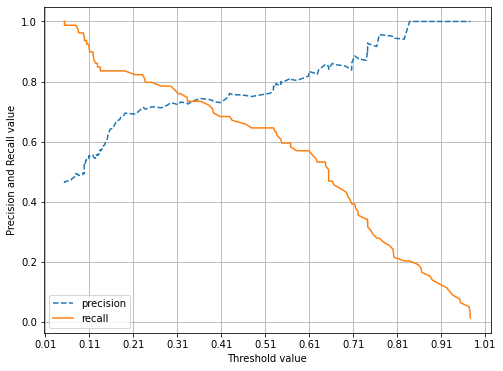

In [63]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    # X축을 thresholdr값으로, Y축은 정밀도, 재현율 값으로 각각 plot수행. 정밀도는 점선
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label='recall')
    
    # threshold 값 X 출의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    
    # X축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value');plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

### 04. F1 스코어
- 정밀도와 재현율 결합한 지표
- 정밀도와 재현율 수치 적절하게 조합돼 분류의 종합적인 성능 평가에 사용될 수 있는 평가
- 어느 한 쪽으로 **치우치지 않는 수치**를 나타낼 때 상대적으로 높은 값을 가짐

$$ F1 = \frac {2}{\frac{1}{recall}+\frac{1}{precision}} = 2*\frac{precision*recall}{precision+recall}$$

#### -> 타이타닉 생존자 예측에서 임계값 변화시키며 F1 스코어 포함 평가 지표 비교해보기

In [72]:
from sklearn.metrics import f1_score

def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    
    # f1 score print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}'.format(accuracy, precision, recall, f1))
          
thresholds = [0.20, 0.25, 0.30, 0.33, 0.35, 0.4, 0.45, 0.50, 0.55]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

--------------------------
임곗값: 0.2
오차행렬
[[71 29]
 [14 65]]
정확도: 0.7598, 정밀도: 0.6915, 재현율: 0.8228, F1: 0.7514
--------------------------
임곗값: 0.25
오차행렬
[[75 25]
 [16 63]]
정확도: 0.7709, 정밀도: 0.7159, 재현율: 0.7975, F1: 0.7545
--------------------------
임곗값: 0.3
오차행렬
[[77 23]
 [18 61]]
정확도: 0.7709, 정밀도: 0.7262, 재현율: 0.7722, F1: 0.7485
--------------------------
임곗값: 0.33
오차행렬
[[78 22]
 [20 59]]
정확도: 0.7654, 정밀도: 0.7284, 재현율: 0.7468, F1: 0.7375
--------------------------
임곗값: 0.35
오차행렬
[[80 20]
 [21 58]]
정확도: 0.7709, 정밀도: 0.7436, 재현율: 0.7342, F1: 0.7389
--------------------------
임곗값: 0.4
오차행렬
[[80 20]
 [25 54]]
정확도: 0.7486, 정밀도: 0.7297, 재현율: 0.6835, F1: 0.7059
--------------------------
임곗값: 0.45
오차행렬
[[83 17]
 [27 52]]
정확도: 0.7542, 정밀도: 0.7536, 재현율: 0.6582, F1: 0.7027
--------------------------
임곗값: 0.5
오차행렬
[[84 16]
 [28 51]]
정확도: 0.7542, 정밀도: 0.7612, 재현율: 0.6456, F1: 0.6986
--------------------------
임곗값: 0.55
오차행렬
[[89 11]
 [32 47]]
정확도: 0.7598, 정밀도: 0.8103, 재현율: 0.5949, F1: 0.6861


### 05. ROC 곡선과 AUC
1. ROC = FPR이 변할 때 TPR이 어떻게 변하는지를 나타내는 곡선
- 임계값을 0부터 1까지 변화시키면서 FPR을 구하고 이 FPR 값의 변화에 따른 TPR 값을 구하는 것이 ROC 곡선

$FPR = \frac{FP}{FP+TN} = 1 - TNR = 1- 특이성$


-> FPR(False Positive Rate) ==> ROC곡선의 X축


    - FPR=0 만들기: FP=0만들기 => 임계값 1로 지정. Positive로 예측하지 않아 FP=0됨
    - FPR=1 만들기: TN=0만들기 => 임계값 0으로 지정

$TPR = \frac{TP}{FN+TP}$


-> TPR(True Positive Rate) = 민감도 = 재현율 ==> ROC곡선의 Y축

$TNR = \frac{TN}{FP+TN}$


-> TNR(True Negative Rate) = 특이성. 민감도에 대응하는 지표

In [77]:
from sklearn.metrics import roc_curve

# 레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
# 반환된 임계값 배열에서 샘플로 데이터를 추출하되, 임계값을 5 step으로 추출
# thresholds[0]은 max(예측확률)+1 로 임이 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임계값 배열의 index:', thr_index)
print('샘플 index로 추출한 임계값: ', np.round(thresholds[thr_index], 2))

# 5step 단위로 추출된 임계값에 따른 FPR, TPR 값
print('샘플 임계값별 FPR: ', np.round(fprs[thr_index], 3))
print('샘플 임계값별 TPR: ', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임계값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46 51 56 61]
샘플 index로 추출한 임계값:  [0.98 0.76 0.71 0.65 0.57 0.53 0.36 0.27 0.19 0.13 0.11 0.1  0.08]
샘플 임계값별 FPR:  [0.   0.02 0.04 0.07 0.11 0.14 0.2  0.25 0.29 0.54 0.58 0.67 0.8 ]
샘플 임계값별 TPR:  [0.013 0.278 0.392 0.506 0.595 0.633 0.734 0.785 0.835 0.848 0.911 0.949
 0.987]


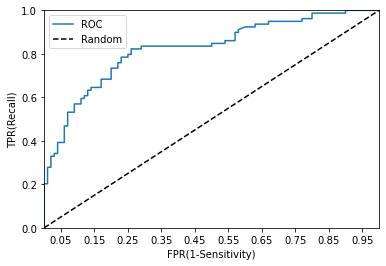

In [80]:
def roc_curve_plot(y_test, pred_proba_c1):
    # 임계값에 따른 RPF, TPR 값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    # ROC 곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label='ROC')
    # 가운데 대각선 직선을 그림
    plt.plot([0,1], [0,1], 'k--', label='Random')
    
    # FPR X축의 scale을 0.1단위로 변경. X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1); plt.ylim(0,1)
    plt.xlabel('FPR(1-Sensitivity)'); plt.ylabel('TPR(Recall)')
    plt.legend()
    
roc_curve_plot(y_test, pred_proba[:,1])

2. AUC(Area Under Curve): ROC 곡선 밑의 면적. 1에 가까울수록 좋은 것
        
        -> AUC 커지려면: FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건
        = 가운데 직선에서 멀어지고 왼쪽 상단 모서리 쪽으로 가파르게 곡선이 이동할수록 직사각형에 가까워져 면적 커짐 
        - 가운데 대각선 직선의 AUC는 0.5. 따라서 보통의 분류는 0.5 이상의 AUC 값을 가짐

*타이타닉 생존자 예측 로지스틱 회귀 모델의 ROC AUC값*

In [81]:
from sklearn.metrics import roc_auc_score

pred_proba = lr_clf.predict_proba(X_test)[:,1]
roc_score = roc_auc_score(y_test, pred_proba)
print('ROC AUC 값: {0:.4f}'.format(roc_score))

ROC AUC 값: 0.8252


In [107]:
def get_clf_eval2(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:4f}, 재현율: {2:4f},\
    F1: {3:.4f}, AUC: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 06. 피마 인디언 당뇨병 예측
- 북아메리카 피마 지역 원주민의 Type-2 당뇨병 결과 데이터
- diabetes.csv

In [104]:
import pandas as pd
diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
print('-------------------------------------------')
diabetes_data.info()
print('-------------------------------------------')
diabetes_data.head(5)

0    500
1    268
Name: Outcome, dtype: int64
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
-------------------------------------------


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


*diabetes_data.info()결과 분석*
- Null값 없으며 피처 타입 모두 숫자형 -> 별도의 피처 인코딩 필요없음

In [108]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

# 피처 데이터 세트X, 레이블 데이터 세트 y 추출
# 맨 끝이 outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval2(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.720930, 재현율: 0.574074,    F1: 0.6392, AUC: 0.7919


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*재현율이 낮으므로 조정 필요 -> 정밀도 재현율 곡선*

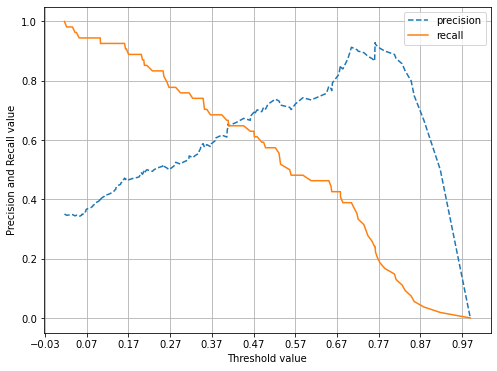

In [109]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

*임계값 0.42정도에서 정밀도와 재현율 어느정도 균형 맞는 것 확인*
*but, 두 개 지표 모두 0.7이 안됨*

In [98]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


*min값이 0인 피처 확인 -> 특히 Glucose는 포도당 수치인데 0값인건 말이 안됨*

In [111]:
# 0값을 검사할 피처 명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

# 피처별로 반복하면서 데이터 값이 0인 데이터 건수 추출하고, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%'.format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


*많은 값이 0인 것을 확인할 수 있음 -> 데이터를 아예 삭제하면 학습을 효과적으로 수행하기 어려우므로 0값을 평균값으로 대체*

In [112]:
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features]=diabetes_data[zero_features].replace(0, mean_zero_features)

In [113]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

# StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

# 로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval2(y_test, pred, pred_proba)

오차행렬
[[89 11]
 [20 34]]
정확도: 0.7987, 정밀도: 0.755556, 재현율: 0.629630,    F1: 0.6869, AUC: 0.8443


C:\Users\USER\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


*어느정도 개선된 것 확인 but 여전히 재현율 수치 떨어져 개선 필요 -> 임계값 비교*

In [116]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50, 0.52]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

--------------------------
임곗값: 0.3
오차행렬
[[68 32]
 [10 44]]
정확도: 0.7273, 정밀도: 0.5789, 재현율: 0.8148, F1: 0.6769
--------------------------
임곗값: 0.33
오차행렬
[[72 28]
 [13 41]]
정확도: 0.7338, 정밀도: 0.5942, 재현율: 0.7593, F1: 0.6667
--------------------------
임곗값: 0.36
오차행렬
[[75 25]
 [15 39]]
정확도: 0.7403, 정밀도: 0.6094, 재현율: 0.7222, F1: 0.6610
--------------------------
임곗값: 0.39
오차행렬
[[79 21]
 [16 38]]
정확도: 0.7597, 정밀도: 0.6441, 재현율: 0.7037, F1: 0.6726
--------------------------
임곗값: 0.42
오차행렬
[[81 19]
 [16 38]]
정확도: 0.7727, 정밀도: 0.6667, 재현율: 0.7037, F1: 0.6847
--------------------------
임곗값: 0.45
오차행렬
[[84 16]
 [18 36]]
정확도: 0.7792, 정밀도: 0.6923, 재현율: 0.6667, F1: 0.6792
--------------------------
임곗값: 0.48
오차행렬
[[87 13]
 [19 35]]
정확도: 0.7922, 정밀도: 0.7292, 재현율: 0.6481, F1: 0.6863
--------------------------
임곗값: 0.5
오차행렬
[[89 11]
 [20 34]]
정확도: 0.7987, 정밀도: 0.7556, 재현율: 0.6296, F1: 0.6869
--------------------------
임곗값: 0.52
오차행렬
[[90 10]
 [22 32]]
정확도: 0.7922, 정밀도: 0.7619, 재현율: 0.5926, F1: 0.6667


In [117]:
# 임계값 0.5로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.5)

# 위에서 구한 lr_clf의 predict_proba() 예측 확률array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_05 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))

get_clf_eval2(y_test, pred_th_05, pred_proba[:,1])

오차행렬
[[89 11]
 [20 34]]
정확도: 0.7987, 정밀도: 0.755556, 재현율: 0.629630,    F1: 0.6869, AUC: 0.8443


### 07. 정리

- 분류의 성능 평가 지표: 정확도, 오차행렬, 정밀도, 재현률, F1 스코어, ROC-AUC
- 이진 분류의 레이블 값이 불균형하게 분포될경우 단순하게 예측해도 정확도 높게 나오는 문제O -> 정확도만으로는 부족
- **오차행렬**: TN, FP, FN, TP 로 매핑되는 4분면 행렬을 기반으로 예측 성능 평가
- **정밀도**, **재현률**: 데이터 세트의 예측 성능에 좀 더 초점을 맞춘 평가 지표
     - 재현율 중요: 암 양성 예측 모델 등의 Positive 데이터를 Negative로 잘못 판단하면 문제 큰 경우
- **F1 스코어**: 정밀도와 재현율을 결합한 평가 지표. 정밀도와 재현율이 어느 한쪽으로 치우치지 않을 때 높은 지표값
- ROC-AUC: 이진 분류의 성능 평가를 위해 가장 많이 사용되는 지표
     - AUC: ROC곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치